# Initialise parameters
All of these parameters are mainly to ensure we are matching, and will locate, the correct generated data from before.

In [1]:
import numpy as np
# Step 0 - initialise parameters
m = 2000 # size of data

no_x_vecs = 200
no_S_mats = 200


logkmin=0
logkmax=np.log10(m)
logknum=15
KLIST=np.logspace(logkmin,logkmax,logknum,base=10)
delta=0.05 # failure prob

In [2]:
choicevec=['normal','uniform','countsketch','QR1','QR2','QR3']#,'constant1']

# Import data
Data is imported from CSV files in the home directory, which were saved by 'Generate' code.

The last code block in this section rounds the highest value of $k$ in `KLIST` *after importing results using the full value*, to enhance readability in plotting.

At this stage everything should be possible to import, except for Discrete $\pm 1$, which has not been implemented completely into the generation code yet.

In [3]:
EpsForK_Dict={}
EpsListDict={}
Something_worked = False
for choicename in choicevec:
    choicename = choicename.capitalize()
    try:
        pathEpslist=f'CSVs/EpsList_k{logkmin}by{logkmax}by{logknum}m{m}for{no_x_vecs}xvecs{no_S_mats}SmatswithDelta{delta}for{choicename}.csv'
        pathEpsForK=f'CSVs/EpsForK_k{logkmin}by{logkmax}by{logknum}m{m}for{no_x_vecs}xvecs{no_S_mats}SmatswithDelta{delta}for{choicename}.csv'
        EpsListDict[choicename]=np.loadtxt(pathEpslist, delimiter=',')
        EpsForK_Dict[choicename]=np.loadtxt(pathEpsForK,delimiter=',')
        print(f'✅ {choicename} loaded')
        Something_worked = True
    except FileNotFoundError:
        print(f'❌ {choicename} not found')
        # it didnt exist so do nothing

# Raise an alert if nothing was found
if not Something_worked:
    raise RuntimeError("No CSV imports have worked. Make sure your parameters exactly match between 'generate' and 'plot' sections, and that you have actually run the generate code first!")


✅ Normal loaded
✅ Uniform loaded
✅ Countsketch loaded
✅ Qr1 loaded
✅ Qr2 loaded
✅ Qr3 loaded


In [4]:
# rounding for nicer graphs
logkmax=np.round(logkmax,1)

---
# Plot
We plot:
* first the error distribution, with some $\delta$'s overlayed, for the highest value of $k$
    * we need to import the function `eps_needed` to do this
* then our main comparison metric error ($\varepsilon_{max}$) vs $k$
* then the alternative comparison metric, $k_{min}$ vs $\varepsilon$ sampled.

In [5]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif',size=18)

In [6]:
def eps_needed(p_succ,eps_list):
    '''
    Input:
    - p_succ (float) between 0 and 1: probability of success
    - eps_list (list) is the list (of epsilons) we want to take a quantile from

    Output:
    - eps_needed (float)
    '''
    return np.percentile(eps_list, 100 * p_succ)

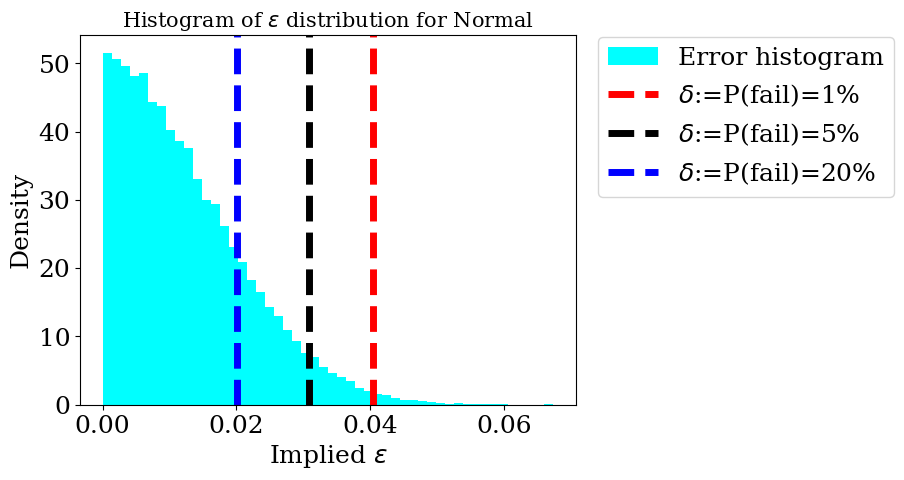

In [7]:
choicename = 'QR1' # EDIT here to the matrix you want to see the Error histogram of.
choicename = choicename.capitalize()
eps_list=EpsListDict[choicename]

plt.xlabel(r'Implied $\varepsilon$')
plt.ylabel('Density')
plt.hist(eps_list, bins=50, color='aqua',density=True,label='Error histogram')
plt.title(fr'Histogram of $\varepsilon$ distribution for {choicename}',size=15)

for delta_loopy,colour in zip([0.01,0.05,0.2],['red','k','blue']):
    epsneed=eps_needed(1-delta_loopy,eps_list)
    plt.axvline(epsneed,color=colour,linewidth=5,linestyle='--',label=fr'$\delta$:=P(fail)={int(100*(delta_loopy))}%')
plt.legend(
    loc='upper left', bbox_to_anchor=(1.02, 1.03)
    )

plt.savefig(f'Plots/k{logkmin}by{logkmax}by{logknum}m{m}for{no_x_vecs}xvecs{no_S_mats}Smatsfor{choicename}_EpsDist.png', bbox_inches='tight')

## Error vs $k$

Keeping track of lists:
* the original `choicevec` contained all the matrices we attempted to generate. 
* `EpsForKDict` now contains all the matrices that could successfully be imported (with keys as `capitalize`d choices)
* `selections` contains the matrices we wish to plot, with entries that shortly get capitalized.
    * thus we intersect the keys of `EpsForKDict` and `selections` to find what we *can* plot call this `EpsForK_Dict_selected`, and plot these.

In [8]:
# Choosing what to plot
selections = [
    'NoRmAl',
    'Uniform',
    'Countsketch',
    'Qr1', 'Qr2', 'Qr3',
    'Discretepm1',
]
selections = [selector.capitalize() for selector in selections] # capitalize selections
EpsForK_Dict_selected = {key: value for key, value in EpsForK_Dict.items() if key in selections}

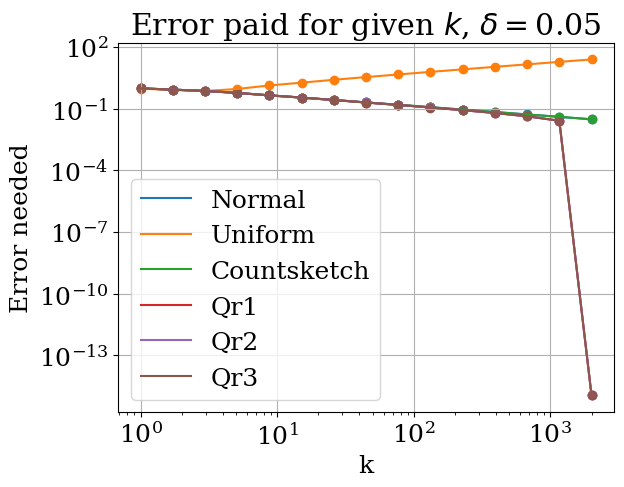

<Figure size 640x480 with 0 Axes>

In [9]:
# Looping through and plotting them
for choicename, EPSNEEDEDFORK in EpsForK_Dict_selected.items(): 
    plt.loglog(KLIST,EPSNEEDEDFORK,label=choicename)
    plt.scatter(KLIST,EPSNEEDEDFORK)

# Grid, labels, axes
plt.grid()
plt.xlabel('k')
plt.ylabel(f'Error needed');
plt.title(rf'Error paid for given $k$, $\delta=${delta}')
plt.legend(
        #fontsize='small',loc='upper left', bbox_to_anchor=(1.02, 1.03)
        )
#plt.ylim(10**(-15.999),10**0.5) # this was used to keep the axes labels consistent when separating out Normal/Countsketch and QR plots.
plt.show()
# Saving the figure
plt.savefig(f'Plots/k{logkmin}by{logkmax}by{logknum}m{m}for{no_x_vecs}xvecs{no_S_mats}SmatsAnd{len(EpsForK_Dict_selected.keys())}choices_ErrorVsK.png', bbox_inches='tight');

Observations based on the above graph tend to be that HIGHER lines correspond to more error for a given $k$, less preservation of closeness of vectors, and thus WORSE subspace embeddings. If new subspace embeddings have been implemented into the code, more specific analysis may be necessary, or conclusions about working well for certain $k$ values but not for others are welcome.

For example, in the above case, QR matrices seem to work better, and normal + countsketch matrices are working worse.

# min $k$ for given $\varepsilon_{\text{max}}$

We now plot the 'alternative' comparison metric: the minimum $k$ required to achieve a certain value of $\varepsilon$. 
Since the value of $\varepsilon$ doesn't actually matter, we can generate any random values we like to sample over.

In order to plot this:
* KLIST is fixed by our generation as the logspace from `10^logkmin` up to `10^logkmax`
* we randomly generate some $\varepsilon$'s, chosen by hand based on graphs present, to ensure a representative sample. These may vary depending on use case.
* for each sample $\varepsilon$, we find the minimum $k$ where all the errors are strictly less than this $\varepsilon$, and call this the minimum k for $\varepsilon$.
    * doing this for all sampled $\varepsilon$'s gives us a set of points we can graph.

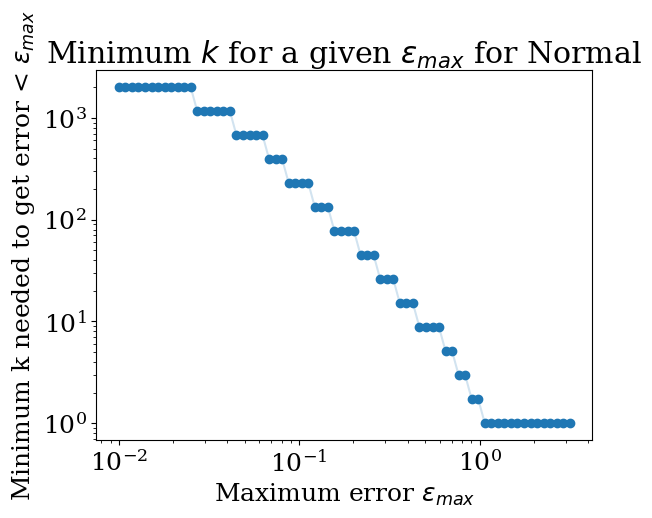

In [10]:
choice='Normal'
## Option for user to input the epsilon they want to check

sample_epsmax_list=np.logspace(-2,0.5,num=70)
min_k_for_epsmax_list = []

for epsmax in sample_epsmax_list:
    try:
        mink = np.min(KLIST[EPSNEEDEDFORK < epsmax])
    except:
        mink = 1.5*10**logkmax # if such a k does not occur, we set this value by default as the maximum.
    min_k_for_epsmax_list.append(mink)

# Labels, title, legend, saving
plt.loglog(sample_epsmax_list,min_k_for_epsmax_list,alpha=0.2)
plt.scatter(sample_epsmax_list,min_k_for_epsmax_list)
plt.xlabel(r'Maximum error $\varepsilon_{max}$')
plt.ylabel(r'Minimum k needed to get error < $\varepsilon_{max}$ ')
plt.title(r'Minimum $k$ for a given $\varepsilon_{max}$ for '+choice)
plt.savefig(f'Plots/k{logkmin}by{logkmax}by{logknum}m{m}for{no_x_vecs}xvecs{no_S_mats}Smatsfor{choice}_MinKforEpsMax_Dist.png')

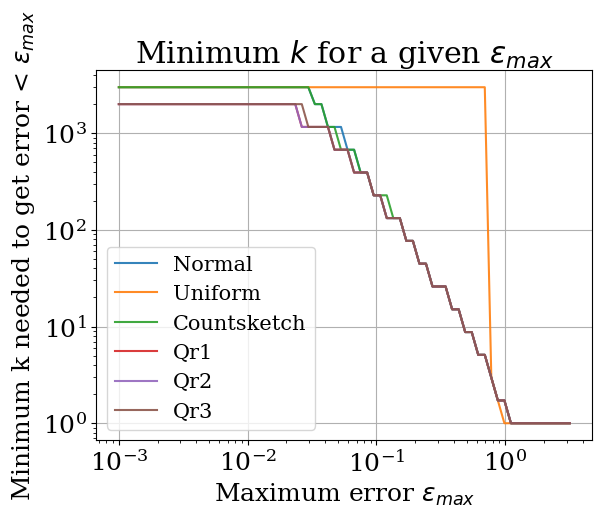

In [11]:
# Sample epsilons are generated. Values here have been chosen by hand based on graphs present, to ensure a representative sample of epsilons, and may vary depending on use case.
sample_epsmax_list=np.logspace(-3,0.5,num=70)

for choicename, EPSNEEDEDFORK in EpsForK_Dict_selected.items(): 
    min_k_for_epsmax_list=[]
    for epsmax in sample_epsmax_list:
        try:
            mink = np.min(KLIST[EPSNEEDEDFORK < epsmax])
        except:
            mink = 1.5*10**logkmax # if such a k does not occur, we set this value by default as the maximum.
        min_k_for_epsmax_list.append(mink)

    plt.loglog(sample_epsmax_list,min_k_for_epsmax_list,alpha=0.9,label=choicename)
    
# Labels, title, legend, saving
plt.xlabel(r'Maximum error $\varepsilon_{max}$')
plt.ylabel(r'Minimum k needed to get error < $\varepsilon_{max}$ ')
plt.title(r'Minimum $k$ for a given $\varepsilon_{max}$')
plt.legend(fontsize='small')
plt.grid()
plt.savefig(f'Plots/k{logkmin}by{logkmax}by{logknum}m{m}for{no_x_vecs}xvecs{no_S_mats}Smats_MinKforEpsMax_Dist.png')

Observations based on the above graph tend also to be that HIGHER lines correspond to a higher dimension needed for given maximum allowable error, and hence WORSE subspace embeddings. Again, if new subspace embeddings have been implemented into the code, more specific analysis may be necessary, or conclusions about working well for certain $k$ values but not for others are welcome.

In the above case, the results are slightly more nuanced, but loosely all forms of QR seem to be the best subspace embedding. (See report for more detail.)